In [ ]:
# =====================================================
# Cell 1: Imports and Scenario Configuration
# =====================================================
# POINT2 Analytical Solution for BHE Field with Groundwater Flow
# Based on Wexler (1992) algorithm and teacher's ex-gwe-bhe.py
#
# KEY INSIGHT from teacher:
# - POINT2 computes AQUIFER temperature (ground temperature at borehole wall)
# - Need to convert to FLUID temperature using R_b:
#   T_fluid = T_borewall + q * R_b
# - This is because EED shows fluid temperature (average of inlet/outlet)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.special import roots_legendre
import json
import time

# === SCENARIO SELECTION ===
# Change this to 'low', 'medium', or 'high'
scenario = 'high'  # <-- Change to 'low', 'medium', or 'high'

# Velocity scenarios (matching MODFLOW)
velocity_scenarios = {
    'low': 0.001,     # m/d - minimal flow
    'medium': 0.1,    # m/d - moderate flow
    'high': 1.0       # m/d - high flow
}

v_darcy = velocity_scenarios[scenario]

print(f"POINT2 Groundwater Flow Sensitivity Analysis")
print(f"Selected scenario: {scenario.upper()}")
print(f"Darcy velocity: {v_darcy} m/d")
print(f"\nMethod: Direct POINT2 + R_b conversion (like teacher's code)")

POINT2 Groundwater Flow Sensitivity Analysis
Selected scenario: LOW
Darcy velocity: 0.001 m/d

Method: Direct POINT2 + R_b conversion (like teacher's code)


In [20]:
# =====================================================
# Cell 2: Model Parameters (matching MODFLOW)
# =====================================================

# === Workspace setup ===
workspace = Path(f"../workspace/point2_gwflow_{scenario}")
workspace.mkdir(parents=True, exist_ok=True)

# === Hydraulic parameters (matching MODFLOW) ===
K = 10.0            # Hydraulic conductivity [m/d]
n_porosity = 0.2    # Porosity [-] (matching teacher's example)

# Pore velocity (linear velocity)
v_pore = v_darcy / n_porosity  # m/d
v_pore_ms = v_pore / 86400     # m/s

# === Thermal parameters (matching MODFLOW/EED) ===
k_ground = 1.4          # Ground thermal conductivity [W/(m·K)]
rho_c = 2.83e6          # Volumetric heat capacity [J/(m³·K)]

# Solid properties
rho_w = 1000.0          # Water density [kg/m³]
c_w = 4184.0            # Water specific heat [J/(kg·K)]
k_w = 0.59              # Water thermal conductivity [W/(m·K)]
k_s = k_ground          # Solid thermal conductivity [W/(m·K)]
rho_s = 2650.0          # Solid density [kg/m³]
c_s = rho_c / rho_s     # Solid specific heat [J/(kg·K)]

# Dispersivity (zero for now, like MODFLOW)
al = 0.0                # Longitudinal dispersivity [m]
ah = 0.0                # Transverse dispersivity [m]

# === Ground temperature ===
T0_surf = 9.6           # Surface temperature [°C]
q_geo = 0.07            # Geothermal heat flux [W/m²]
grad_T = q_geo / k_ground  # Geothermal gradient [°C/m]

# === BHE field configuration (matching MODFLOW) ===
n_x, n_y = 5, 8         # Borehole array dimensions
n_bhe = n_x * n_y       # Total boreholes = 40
H = 147.0               # Borehole depth [m]
B = 7.0                 # Borehole spacing [m]
r_b = 0.07              # Borehole radius [m]
R_b = 0.1271            # Borehole thermal resistance [(m·K)/W]

# Effective ground temperature at mid-depth
T0_eff = T0_surf + grad_T * H / 2

# === Simulation time ===
n_yr = 25               # Simulation period [years]
n_mo = n_yr * 12        # Total months
sec_per_mo = 730 * 3600 # Seconds per month
L_total = n_bhe * H     # Total borehole length [m]
hrs_per_mo = 730.0

print("="*60)
print(f"POINT2 Analytical Solution - {scenario.upper()} Velocity")
print("="*60)
print(f"\nHydraulic parameters:")
print(f"  K = {K} m/d")
print(f"  Porosity = {n_porosity}")
print(f"  Darcy velocity = {v_darcy} m/d")
print(f"  Pore velocity = {v_pore:.4f} m/d = {v_pore_ms:.2e} m/s")
print(f"\nThermal parameters:")
print(f"  k = {k_ground} W/(m·K)")
print(f"  rho_c = {rho_c/1e6:.2f} MJ/(m³·K)")
print(f"  T0_eff = {T0_eff:.2f} deg C")
print(f"\nBHE configuration:")
print(f"  {n_x} x {n_y} = {n_bhe} boreholes")
print(f"  H = {H} m, B = {B} m")
print(f"  R_b = {R_b} (m·K)/W")

POINT2 Analytical Solution - LOW Velocity

Hydraulic parameters:
  K = 10.0 m/d
  Porosity = 0.2
  Darcy velocity = 0.001 m/d
  Pore velocity = 0.0050 m/d = 5.79e-08 m/s

Thermal parameters:
  k = 1.4 W/(m·K)
  rho_c = 2.83 MJ/(m³·K)
  T0_eff = 13.28 deg C

BHE configuration:
  5 x 8 = 40 boreholes
  H = 147.0 m, B = 7.0 m
  R_b = 0.1271 (m·K)/W


In [3]:
# =====================================================
# Cell 3: POINT2 Algorithm Implementation
# =====================================================
# Directly from teacher's ex-gwe-bhe.py (Wexler 1992)

def integrand_point2(tau, x, y, v, Dx, Dy, xc, yc, lamb):
    return (
        1
        / tau
        * np.exp(
            -(v**2 / (4 * Dx) + lamb) * tau
            - (x - xc) ** 2 / (4 * Dx * tau)
            - (y - yc) ** 2 / (4 * Dy * tau)
        )
    )


def point2(c0, x, y, t, v, n, al, ah, Qa, xc, yc, Dm=0, lamb=0, R=1.0, order=100):
    """
    Compute the 2D concentration field from a continuous point source.
    Source: Wexler (1992) - POINT2 algorithm (equation 76).
    """
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    t = np.atleast_1d(t)

    Dx = al * v + Dm
    Dy = ah * v + Dm

    # apply retardation coefficient
    v = v / R
    Dx = Dx / R
    Dy = Dy / R
    Qa = Qa / R

    if len(t) > 1 and (len(x) > 1 or len(y) > 1):
        raise ValueError(
            "If multiple values for t are specified, only one x and y value are allowed"
        )

    root, weights = roots_legendre(order)

    def integrate(t, x, y):
        F = (
            integrand_point2(
                root * (t - 0) / 2 + (0 + t) / 2, x, y, v, Dx, Dy, xc, yc, lamb
            ).dot(weights)
            * (t - 0)
            / 2
        )
        return F

    integrate_vec = np.vectorize(integrate)

    term = integrate_vec(t, x, y)
    term0 = Qa / (4 * n * np.pi * np.sqrt(Dx * Dy)) * np.exp(v * (x - xc) / (2 * Dx))

    return c0 * term0 * term


def bhe(
    Finj, x, y, t, xc, yc, v, n, rho_s, c_s, k_s,
    rho_w=1000.0, c_w=4184.0, k_w=0.59, al=0.0, ah=0.0, T0=0.0, order=100,
):
    """
    Simulate the effect of multiple BHEs with time-varying thermal loads.
    Directly from teacher's ex-gwe-bhe.py implementation.
    """
    Finj = np.atleast_2d(Finj)
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    t = np.atleast_1d(t)
    xc = np.atleast_1d(xc)
    yc = np.atleast_1d(yc)

    inj_time = Finj[:, 0]
    Finj = Finj[:, 1:]
    nbhe = Finj.shape[1]

    if not len(xc) == len(yc) == nbhe:
        raise ValueError("xc and yc must have the same length as number of BHEs")

    # Compute corresponding solute transport parameters
    kd = c_s / (c_w * rho_w)
    k0 = n * k_w + (1 - n) * k_s
    Dm = k0 / (n * rho_w * c_w)
    rho_b = (1 - n) * rho_s
    R = 1 + kd * rho_b / n

    # Define mass injection rates
    Finj = Finj / (rho_w * c_w)  # W/m -> m²/s * K
    Qa = 1.0  # Unity [L²/T]

    def calculate_temp(inj, ti):
        """Calculate temperature changes for all BHEs at a given time."""
        for i in range(len(inj)):
            if i == 0:
                c = point2(
                    c0=inj[i], x=x, y=y, t=ti, v=v, n=n,
                    al=al, ah=ah, Qa=Qa, xc=xc[i], yc=yc[i],
                    Dm=Dm, R=R, order=order,
                )
            else:
                c += point2(
                    c0=inj[i], x=x, y=y, t=ti, v=v, n=n,
                    al=al, ah=ah, Qa=Qa, xc=xc[i], yc=yc[i],
                    Dm=Dm, R=R, order=order,
                )
        return c

    # Time series at one location
    inj_time_valid = inj_time[inj_time <= np.max(t)]
    if len(inj_time_valid) == 0:
        raise ValueError("No loading times prior to t.")

    for ix, tinj in enumerate(inj_time_valid):
        tix = t > tinj
        nt = len(t[tix])
        if ix == 0:
            temp = np.nan_to_num(calculate_temp(Finj[ix], t - tinj), nan=0.0)
        elif nt > 0:
            temp[tix] = temp[tix] + np.nan_to_num(
                calculate_temp(Finj[ix] - Finj[ix - 1], t[tix] - tinj), nan=0.0
            )

    return temp + T0

print("POINT2 functions (from teacher's code) defined successfully.")

POINT2 functions (from teacher's code) defined successfully.


In [4]:
# =====================================================
# Cell 4: BHE Configuration and Load Definition
# =====================================================
# KEY INSIGHT from teacher:
# - POINT2 calculates AQUIFER temperature (ground temperature)
# - Need to convert to BHE FLUID temperature using borehole resistance R_b
# - T_fluid = T_borewall + q * R_b
# - For injection (q>0): T_fluid > T_borewall (fluid is hotter)
# - For extraction (q<0): T_fluid < T_borewall (fluid is colder)

# BHE positions (centered at origin)
field_x = (n_x - 1) * B   # BHE field width = 28m
field_y = (n_y - 1) * B   # BHE field length = 49m

# BHE coordinates
bhe_x = []
bhe_y = []
for i in range(n_x):
    for j in range(n_y):
        bhe_x.append((i - (n_x-1)/2) * B)
        bhe_y.append((j - (n_y-1)/2) * B)

bhe_x = np.array(bhe_x)
bhe_y = np.array(bhe_y)

# Find the center BHE (closest to origin)
distances_to_origin = np.sqrt(bhe_x**2 + bhe_y**2)
center_bhe_idx = np.argmin(distances_to_origin)
center_bhe_x = bhe_x[center_bhe_idx]
center_bhe_y = bhe_y[center_bhe_idx]

# Observation point: at borehole wall distance from center BHE
r_obs = r_b  # Observe at borehole wall
obs_x = center_bhe_x + r_obs
obs_y = center_bhe_y

print(f"BHE array: {n_x} x {n_y} = {n_bhe} boreholes")
print(f"BHE X range: {bhe_x.min():.1f} to {bhe_x.max():.1f} m")
print(f"BHE Y range: {bhe_y.min():.1f} to {bhe_y.max():.1f} m")
print(f"\nCenter BHE: ({center_bhe_x:.1f}, {center_bhe_y:.1f}) m")
print(f"Observation point: ({obs_x:.4f}, {obs_y:.2f}) m at r_b = {r_obs} m from center BHE")

# === Monthly BUILDING loads (SEP-AUG format, matching MODFLOW) ===
# BUILDING load sign convention:
#   Positive = building needs heating = extract heat FROM ground
#   Negative = building needs cooling = inject heat TO ground
L_MWh_sep = np.array([0., 7.37, 12.3, 19.6, 22.1, 19.6, 12.3, 4.91, 0., -19.6, -39.2, -39.2])

# Convert to BHE load (W/m)
# BHE load sign convention (for POINT2 and T_fluid calculation):
#   Positive q = inject heat TO ground (cooling mode, summer)
#   Negative q = extract heat FROM ground (heating mode, winter)
# So we need to NEGATE the building load!
def MWh_to_Wm(MWh):
    return MWh * 1e6 / hrs_per_mo / L_total

q_Wm_sep = np.array([-MWh_to_Wm(x) for x in L_MWh_sep])  # NEGATED!

print(f"\nBuilding loads (MWh): {L_MWh_sep.min():.1f} to {L_MWh_sep.max():.1f}")
print(f"BHE loads (W/m): {q_Wm_sep.min():.2f} to {q_Wm_sep.max():.2f}")
print(f"  - Positive q = injection (summer cooling)")
print(f"  - Negative q = extraction (winter heating)")

# Verify: 
# - Winter (DEC-FEB): building needs heat → extract from ground → q < 0 ✓
# - Summer (JUN-AUG): building needs cooling → inject to ground → q > 0 ✓

# EED reference data (JAN-DEC) - for comparison
eed_base = np.array([10.5, 10.6, 11.3, 12.3, 13.0, 15.4, 17.9, 18.2, 13.9, 12.7, 12.0, 10.9])
eed_25yr = np.tile(eed_base, n_yr)
eed_peak_heat_jan = 6.91
eed_peak_cool_aug = 22.4

print(f"\nBorehole thermal resistance R_b = {R_b:.4f} (m·K)/W")
print(f"Temperature conversion: T_fluid = T_borewall + q * R_b")
print(f"  - Winter (q<0): T_fluid < T_borewall (fluid colder than ground)")
print(f"  - Summer (q>0): T_fluid > T_borewall (fluid hotter than ground)")

BHE array: 5 x 8 = 40 boreholes
BHE X range: -14.0 to 14.0 m
BHE Y range: -24.5 to 24.5 m

Center BHE: (0.0, -3.5) m
Observation point: (0.0700, -3.50) m at r_b = 0.07 m from center BHE

Building loads (MWh): -39.2 to 22.1
BHE loads (W/m): -5.15 to 9.13
  - Positive q = injection (summer cooling)
  - Negative q = extraction (winter heating)

Borehole thermal resistance R_b = 0.1271 (m·K)/W
Temperature conversion: T_fluid = T_borewall + q * R_b
  - Winter (q<0): T_fluid < T_borewall (fluid colder than ground)
  - Summer (q>0): T_fluid > T_borewall (fluid hotter than ground)


In [5]:
# =====================================================
# Cell 5: Prepare Injection Schedule for POINT2
# =====================================================
# Following teacher's approach: direct POINT2 calculation
# The key is to observe at a distance from BHEs where the solution is valid

# Create time array (in seconds)
time_months = np.arange(n_mo + 1) * sec_per_mo  # Start times of each month

# Create Finj array: [time, load_bhe1, load_bhe2, ..., load_bheN]
# POINT2 uses load per unit thickness (W/m)
# For 2D horizontal slice, use q_Wm directly (same as teacher)
Finj_list = []
for i_mo in range(n_mo):
    sep_idx = i_mo % 12  # Index in SEP-AUG cycle
    q_Wm = q_Wm_sep[sep_idx]  # W/m per BHE
    row = [time_months[i_mo]] + [q_Wm] * n_bhe
    Finj_list.append(row)

Finj = np.array(Finj_list)

print(f"Finj shape: {Finj.shape}")
print(f"  - Rows: {Finj.shape[0]} (months)")
print(f"  - Columns: 1 (time) + {Finj.shape[1]-1} (BHE loads)")
print(f"\nTime range: 0 to {Finj[-1,0]/86400/365:.1f} years")
print(f"Load range: {Finj[:,1:].min():.2f} to {Finj[:,1:].max():.2f} W/m")

# For comparison: teacher's load range was -50 to +50 W/m
# Our load range is -9.13 to +5.15 W/m (smaller, realistic building loads)

Finj shape: (300, 41)
  - Rows: 300 (months)
  - Columns: 1 (time) + 40 (BHE loads)

Time range: 0 to 24.9 years
Load range: -5.15 to 9.13 W/m


In [6]:
# =====================================================
# Cell 6: Run POINT2 Calculation - Direct Method
# =====================================================
# Like teacher's code: compute temperature directly at observation point
# The observation point should be outside the BHE field to avoid singularity
# but close enough to capture the thermal response

print(f"Running POINT2 for {scenario.upper()} velocity scenario...")
print(f"  Pore velocity: {v_pore_ms:.2e} m/s")

# Output times: end of each month
t_out = time_months[1:]  # End of each month

t_start = time.time()

# Calculate temperature at observation point
# T0=0 to get temperature CHANGE (like teacher)
dT_ground = bhe(
    Finj=Finj,
    x=obs_x,
    y=obs_y,
    t=t_out,
    xc=bhe_x,
    yc=bhe_y,
    v=v_pore_ms,
    n=n_porosity,
    rho_s=rho_s,
    c_s=c_s,
    k_s=k_s,
    rho_w=rho_w,
    c_w=c_w,
    k_w=k_w,
    al=al,
    ah=ah,
    T0=0.0,  # Get temperature CHANGE, not absolute
    order=50
)

t_end = time.time()
sim_time_min = (t_end - t_start) / 60

# Absolute ground temperature at observation point
T_ground = T0_eff + dT_ground

print(f"\nPOINT2 calculation completed!")
print(f"  Computation time: {sim_time_min:.1f} minutes")
print(f"\nTemperature change at observation point: {dT_ground.min():.2f} to {dT_ground.max():.2f} deg C")
print(f"Absolute temperature at observation point: {T_ground.min():.2f} to {T_ground.max():.2f} deg C")

Running POINT2 for HIGH velocity scenario...
  Pore velocity: 5.79e-05 m/s

POINT2 calculation completed!
  Computation time: 0.4 minutes

Temperature change at observation point: -1.73 to 2.18 deg C
Absolute temperature at observation point: 11.55 to 15.46 deg C


In [7]:
# =====================================================
# Cell 7: Convert Aquifer Temperature to Fluid Temperature
# =====================================================
# KEY INSIGHT from teacher:
# - POINT2 gives AQUIFER temperature (T_borewall = dT_ground)
# - EED shows FLUID temperature (average of inlet/outlet)
# - Need to add the temperature drop/rise across borehole resistance:
#
#   T_fluid = T_borewall + q * R_b
#
# where:
#   - T_borewall = T0_eff + dT_ground (absolute ground temp at borehole wall)
#   - q = heat load (W/m), positive for injection, negative for extraction
#   - R_b = borehole thermal resistance (m·K/W)
#
# Physical meaning:
#   - Injection (q > 0): fluid is HOTTER than ground → T_fluid > T_borewall
#   - Extraction (q < 0): fluid is COLDER than ground → T_fluid < T_borewall

# Monthly loads for each time step (SEP-start, same as POINT2 output)
q_Wm_all = np.tile(q_Wm_sep, n_yr)[:n_mo]

# Temperature at borehole wall from POINT2
T_bw = T0_eff + dT_ground  # Absolute temperature at borehole wall (°C)

# Convert to fluid temperature
# T_fluid = T_borewall + q * R_b
dT_Rb = q_Wm_all * R_b  # Temperature difference across borehole resistance
Tf = T_bw + dT_Rb       # Fluid temperature

print(f"\n=== Temperature Conversion (SEP-start, {n_mo} months) ===")
print(f"\nGround temperature at borehole wall (from POINT2):")
print(f"  dT_ground: {dT_ground.min():.2f} to {dT_ground.max():.2f} °C")
print(f"  T_borewall: {T_bw.min():.2f} to {T_bw.max():.2f} °C")

print(f"\nTemperature across R_b (q * R_b):")
print(f"  R_b = {R_b:.4f} (m·K)/W")
print(f"  q range: {q_Wm_all.min():.2f} to {q_Wm_all.max():.2f} W/m")
print(f"  dT_Rb: {dT_Rb.min():.2f} to {dT_Rb.max():.2f} °C")

print(f"\nFluid temperature (T_fluid = T_borewall + q*R_b):")
print(f"  T_fluid: {Tf.min():.2f} to {Tf.max():.2f} °C")

# Convert from SEP-start to JAN-start format for comparison with EED
idx_map = [4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3]  # SEP-AUG → JAN-DEC
n_years_complete = n_mo // 12

Tf_jan = np.zeros(n_years_complete * 12)
T_bw_jan = np.zeros(n_years_complete * 12)
q_jan = np.zeros(n_years_complete * 12)

for yr in range(n_years_complete):
    for m_new, m_old in enumerate(idx_map):
        Tf_jan[yr*12 + m_new] = Tf[yr*12 + m_old]
        T_bw_jan[yr*12 + m_new] = T_bw[yr*12 + m_old]
        q_jan[yr*12 + m_new] = q_Wm_all[yr*12 + m_old]

# EED baseline (JAN-start)
eed_compare = eed_25yr[:n_years_complete * 12]

mae_vs_eed = np.mean(np.abs(Tf_jan - eed_compare))
rmse_vs_eed = np.sqrt(np.mean((Tf_jan - eed_compare)**2))

print(f"\n=== Comparison with EED (JAN-start) ===")
print(f"POINT2 fluid temperature: {Tf_jan.min():.2f} to {Tf_jan.max():.2f} °C")
print(f"EED baseline: {eed_compare.min():.2f} to {eed_compare.max():.2f} °C")
print(f"\nMAE vs EED: {mae_vs_eed:.3f} °C")
print(f"RMSE vs EED: {rmse_vs_eed:.3f} °C")


=== Temperature Conversion (SEP-start, 300 months) ===

Ground temperature at borehole wall (from POINT2):
  dT_ground: -1.73 to 2.18 °C
  T_borewall: 11.55 to 15.46 °C

Temperature across R_b (q * R_b):
  R_b = 0.1271 (m·K)/W
  q range: -5.15 to 9.13 W/m
  dT_Rb: -0.65 to 1.16 °C

Fluid temperature (T_fluid = T_borewall + q*R_b):
  T_fluid: 10.97 to 16.62 °C

=== Comparison with EED (JAN-start) ===
POINT2 fluid temperature: 10.97 to 16.62 °C
EED baseline: 10.50 to 18.20 °C

MAE vs EED: 1.134 °C
RMSE vs EED: 1.322 °C


Peak load: 160 kW = 27.21 W/m
Peak dT across R_b: 3.46 °C


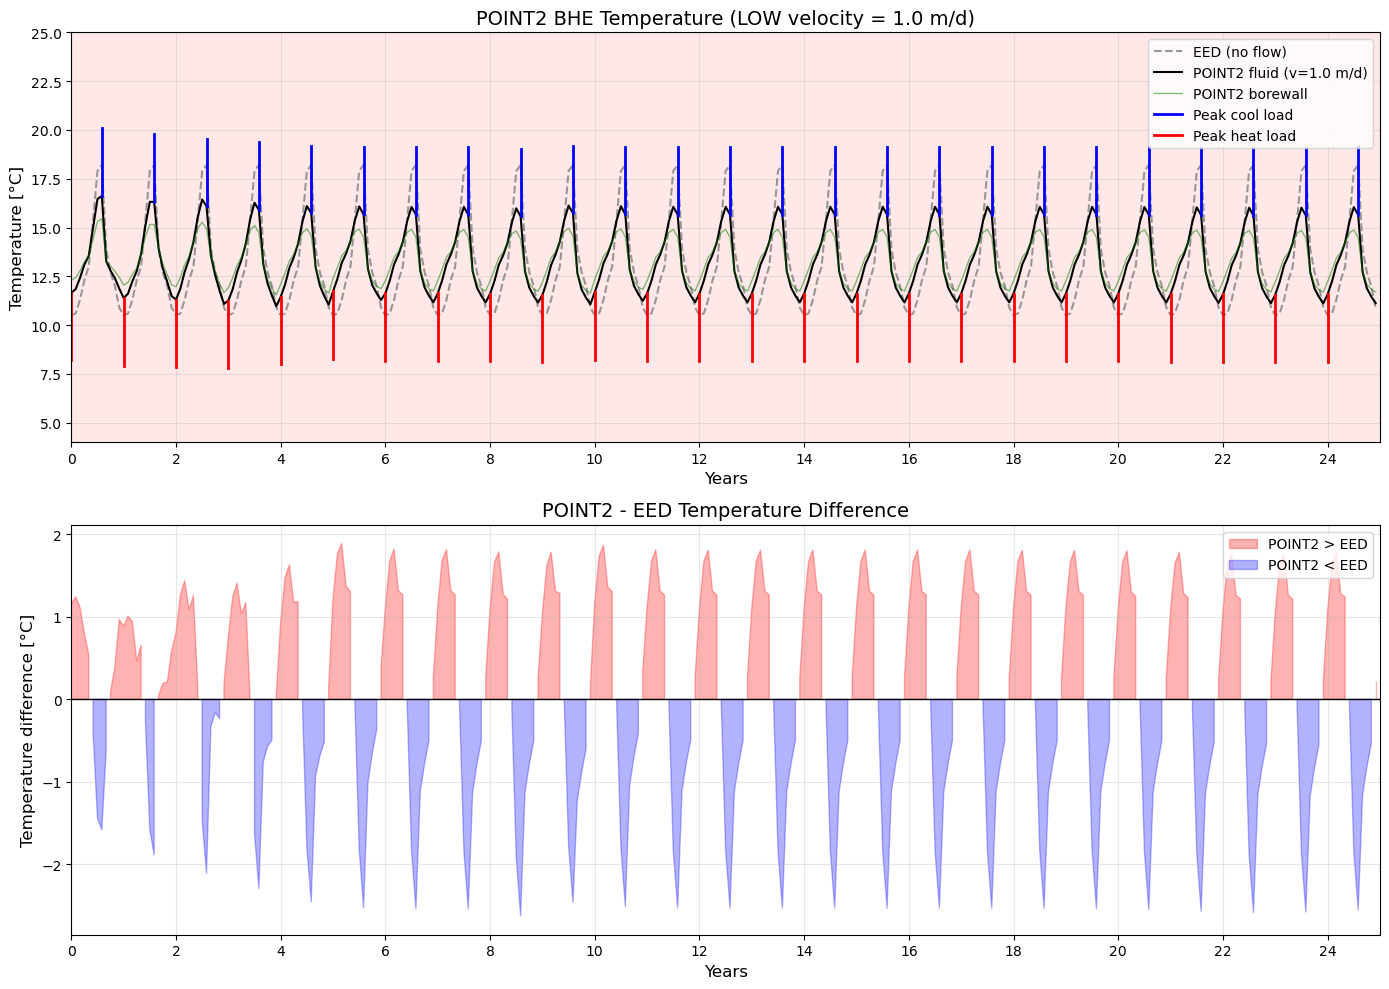


✓ Plot saved to ..\workspace\point2_gwflow_high\point2_temperature_high.png


In [85]:
# =====================================================
# Cell 8: Plot Results - Temperature Time Series
# =====================================================

# Peak load calculation
peak_power = 160 * 1000  # W
peak_Wm = peak_power / L_total  # W/m
delta_T_peak = peak_Wm * R_b

print(f"Peak load: {peak_power/1000:.0f} kW = {peak_Wm:.2f} W/m")
print(f"Peak dT across R_b: {delta_T_peak:.2f} °C")

# Number of complete periods
n_periods_complete = n_years_complete * 12

# Generate peak temperature arrays
Tf_peak_heat = Tf_jan.copy()
Tf_peak_cool = Tf_jan.copy()
for yr in range(n_years_complete):
    Tf_peak_heat[yr * 12 + 0] -= delta_T_peak  # JAN heat extraction
    Tf_peak_cool[yr * 12 + 7] += delta_T_peak  # AUG heat injection

# EED peak arrays
eed_peak_h = eed_compare.copy()
eed_peak_c = eed_compare.copy()
for yr in range(n_years_complete):
    eed_peak_h[yr * 12 + 0] = eed_peak_heat_jan
    eed_peak_c[yr * 12 + 7] = eed_peak_cool_aug

# X-axis
x_years = np.arange(n_periods_complete) / 12.0

# === Plotting ===
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# --- Subplot 1: Temperature comparison ---
ax = axes[0]
ax.set_facecolor('#ffe8e8')

# EED Base Load (gray dashed line)
ax.plot(x_years, eed_compare, color='gray', ls='--', lw=1.5, alpha=0.8, label='EED (no flow)')

# POINT2 Base Load (black solid line)
ax.plot(x_years, Tf_jan, 'k-', lw=1.5, label=f'POINT2 fluid (v={v_darcy} m/d)')

# Also show borehole wall temperature
ax.plot(x_years, T_bw_jan, 'g-', lw=1, alpha=0.5, label='POINT2 borewall')

# Peak loads
for yr in range(n_years_complete):
    aug_idx = yr * 12 + 7
    jan_idx = yr * 12 + 0
    x_aug = x_years[aug_idx]
    x_jan = x_years[jan_idx]
    
    # POINT2 peaks (solid)
    ax.plot([x_aug, x_aug], [Tf_jan[aug_idx], Tf_peak_cool[aug_idx]], 'b-', lw=2)
    ax.plot([x_jan, x_jan], [Tf_jan[jan_idx], Tf_peak_heat[jan_idx]], 'r-', lw=2)

# Legend
ax.plot([], [], 'b-', lw=2, label='Peak cool load')
ax.plot([], [], 'r-', lw=2, label='Peak heat load')

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Temperature [°C]', fontsize=12)
ax.set_title(f'POINT2 BHE Temperature (LOW velocity = {v_darcy} m/d)', fontsize=14)
ax.set_xlim(0, n_years_complete)
ax.set_ylim(4, 25)
ax.set_xticks(range(0, n_years_complete+1, 2))
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)

# --- Subplot 2: Difference between POINT2 and EED ---
ax2 = axes[1]
diff = Tf_jan - eed_compare
ax2.fill_between(x_years, diff, 0, where=(diff >= 0), color='red', alpha=0.3, label='POINT2 > EED')
ax2.fill_between(x_years, diff, 0, where=(diff < 0), color='blue', alpha=0.3, label='POINT2 < EED')
ax2.axhline(0, color='black', ls='-', lw=1)
ax2.set_xlabel('Years', fontsize=12)
ax2.set_ylabel('Temperature difference [°C]', fontsize=12)
ax2.set_title('POINT2 - EED Temperature Difference', fontsize=14)
ax2.set_xlim(0, n_years_complete)
ax2.set_xticks(range(0, n_years_complete+1, 2))
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(workspace / f'point2_temperature_{scenario}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {workspace / f'point2_temperature_{scenario}.png'}")

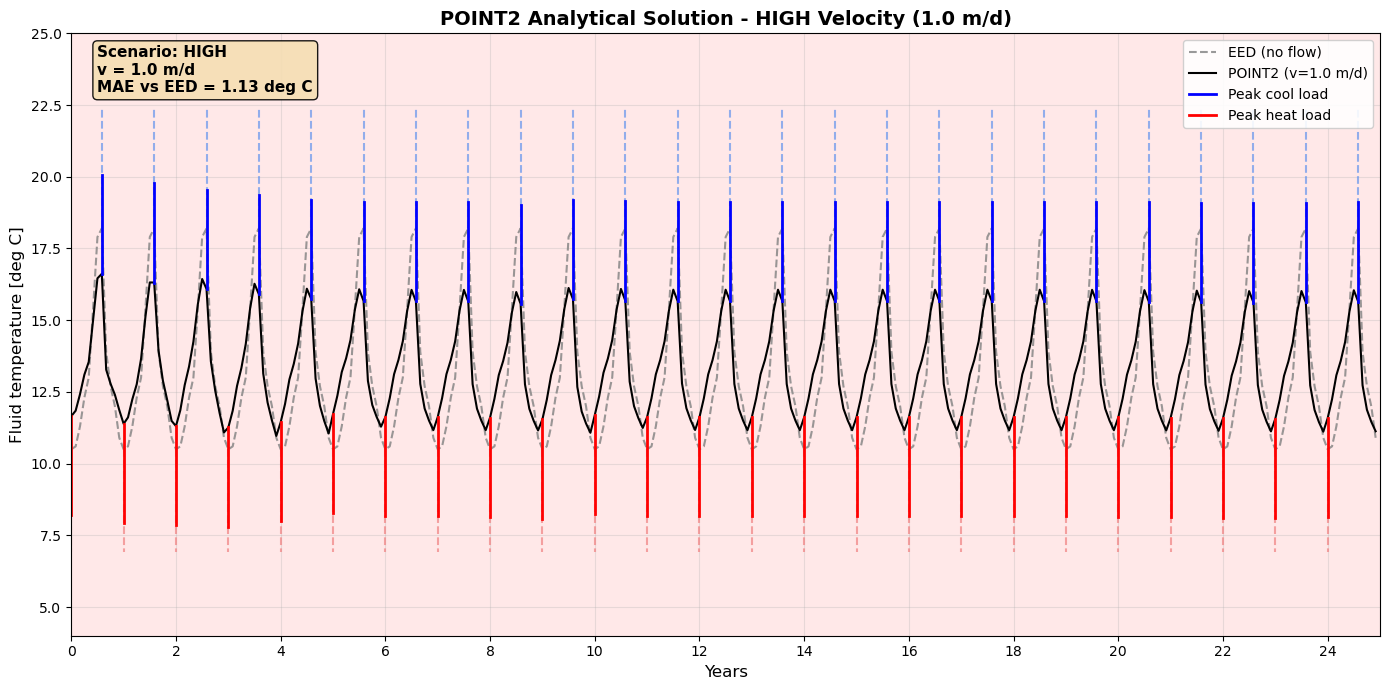


Figure saved to ..\figures\point2_gwflow_high.png


In [86]:
# =====================================================
# Cell 8: Plot Results - Temperature Time Series
# =====================================================

# Peak load calculation
peak_power = 160 * 1000  # W
peak_Wm = peak_power / L_total  # W/m
delta_T_peak = peak_Wm * R_b

# Generate peak temperature arrays
Tf_peak_heat = Tf_jan.copy()
Tf_peak_cool = Tf_jan.copy()
for yr in range(n_years_complete):
    Tf_peak_heat[yr * 12 + 0] -= delta_T_peak  # JAN heat extraction
    Tf_peak_cool[yr * 12 + 7] += delta_T_peak  # AUG heat injection

# EED peak arrays
eed_peak_h = eed_compare.copy()
eed_peak_c = eed_compare.copy()
for yr in range(n_years_complete):
    eed_peak_h[yr * 12 + 0] = eed_peak_heat_jan
    eed_peak_c[yr * 12 + 7] = eed_peak_cool_aug

# X-axis
x_years = np.arange(n_periods_complete) / 12.0

# === Plotting ===
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('#ffe8e8')

# EED Base Load (gray dashed line)
ax.plot(x_years, eed_compare, color='gray', ls='--', lw=1.5, alpha=0.8, label='EED (no flow)')

# POINT2 Base Load (black solid line)
ax.plot(x_years, Tf_jan, 'k-', lw=1.5, label=f'POINT2 (v={v_darcy} m/d)')

# Peak loads
for yr in range(n_years_complete):
    aug_idx = yr * 12 + 7
    jan_idx = yr * 12 + 0
    x_aug = x_years[aug_idx]
    x_jan = x_years[jan_idx]
    
    # EED peaks (dashed)
    ax.plot([x_aug, x_aug], [eed_compare[aug_idx], eed_peak_c[aug_idx]], 
            color='cornflowerblue', ls='--', lw=1.5, alpha=0.7)
    ax.plot([x_jan, x_jan], [eed_compare[jan_idx], eed_peak_h[jan_idx]], 
            color='lightcoral', ls='--', lw=1.5, alpha=0.7)
    
    # POINT2 peaks (solid)
    ax.plot([x_aug, x_aug], [Tf_jan[aug_idx], Tf_peak_cool[aug_idx]], 'b-', lw=2)
    ax.plot([x_jan, x_jan], [Tf_jan[jan_idx], Tf_peak_heat[jan_idx]], 'r-', lw=2)

# Legend
ax.plot([], [], 'b-', lw=2, label='Peak cool load')
ax.plot([], [], 'r-', lw=2, label='Peak heat load')

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Fluid temperature [deg C]', fontsize=12)
ax.set_xlim(0, n_years_complete)
ax.set_ylim(4, 25)
ax.set_xticks(range(0, n_years_complete+1, 2))
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', framealpha=0.9)

# Title
ax.set_title(f'POINT2 Analytical Solution - {scenario.upper()} Velocity ({v_darcy} m/d)', 
             fontsize=14, fontweight='bold')

# Stats box
stats_text = f"Scenario: {scenario.upper()}\nv = {v_darcy} m/d\nMAE vs EED = {mae_vs_eed:.2f} deg C"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, ha='left', va='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

plt.tight_layout()

# Save figure
fig_path = Path(f"../figures/point2_gwflow_{scenario}.png")
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFigure saved to {fig_path}")

In [87]:
# =====================================================
# Cell 9: Save Results for Comparison
# =====================================================

# Save results to file for later comparison
results = {
    'scenario': scenario,
    'velocity_md': v_darcy,
    'n_years': n_years_complete,
    'Tf_jan': Tf_jan.tolist(),
    'T_bw_jan': T_bw_jan.tolist(),  # Borehole wall temperature
    'mae_vs_eed': float(mae_vs_eed),
    'rmse_vs_eed': float(rmse_vs_eed),
    'Tf_min': float(Tf_jan.min()),
    'Tf_max': float(Tf_jan.max()),
    'dT_ground_min': float(dT_ground.min()),
    'dT_ground_max': float(dT_ground.max()),
    'simulation_time_min': sim_time_min,
    'obs_point': [float(obs_x), float(obs_y)],
    'method': 'POINT2 direct + R_b conversion',
    'formula': 'T_fluid = T_borewall + q * R_b'
}

output_path = workspace / f'point2_gwflow_{scenario}_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {output_path}")

print("\n" + "="*60)
print(f"SUMMARY - POINT2 {scenario.upper()} VELOCITY SCENARIO")
print("="*60)
print(f"Darcy velocity: {v_darcy} m/d")
print(f"Pore velocity: {v_pore:.4f} m/d")
print(f"Computation time: {sim_time_min:.1f} minutes")
print(f"\nGround temperature change (at borehole wall):")
print(f"  dT_ground: {dT_ground.min():.2f} to {dT_ground.max():.2f} °C")
print(f"\nFluid temperature (T_fluid = T_borewall + q*R_b):")
print(f"  T_fluid: {Tf_jan.min():.2f} to {Tf_jan.max():.2f} °C")
print(f"\nComparison with EED (no flow):")
print(f"  EED range: {eed_compare.min():.2f} to {eed_compare.max():.2f} °C")
print(f"  MAE = {mae_vs_eed:.3f} °C")
print(f"  RMSE = {rmse_vs_eed:.3f} °C")

Results saved to ..\workspace\point2_gwflow_high\point2_gwflow_high_results.json

SUMMARY - POINT2 HIGH VELOCITY SCENARIO
Darcy velocity: 1.0 m/d
Pore velocity: 5.0000 m/d
Computation time: 0.4 minutes

Ground temperature change (at borehole wall):
  dT_ground: -1.73 to 2.18 °C

Fluid temperature (T_fluid = T_borewall + q*R_b):
  T_fluid: 10.97 to 16.62 °C

Comparison with EED (no flow):
  EED range: 10.50 to 18.20 °C
  MAE = 1.134 °C
  RMSE = 1.322 °C


In [88]:
# =====================================================
# Cell 10: Analyze Temperature Amplitude Per Year
# =====================================================
# Check if amplitude is increasing or decreasing over years

print("="*70)
print("ANALYSIS: Temperature Amplitude Per Year")
print("="*70)

# Analyze each year
print("\nYear-by-Year Analysis:")
print("-" * 60)
print(f"{'Year':<6} {'Min Tf [°C]':<12} {'Max Tf [°C]':<12} {'Amplitude [°C]':<14} {'Min Month':<10} {'Max Month':<10}")
print("-" * 60)

months_names = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

for yr in range(n_years_complete):
    yr_data = Tf_jan[yr*12:(yr+1)*12]
    min_val = yr_data.min()
    max_val = yr_data.max()
    amplitude = max_val - min_val
    min_month = months_names[np.argmin(yr_data)]
    max_month = months_names[np.argmax(yr_data)]
    print(f"{yr+1:<6} {min_val:<12.2f} {max_val:<12.2f} {amplitude:<14.2f} {min_month:<10} {max_month:<10}")

# Summary
print("\n" + "="*70)
print("Key Observations:")
print("="*70)

# First vs last 5 years
first_5yr = Tf_jan[:60]
last_5yr = Tf_jan[-60:]

print(f"\nFirst 5 years: Min={first_5yr.min():.2f}°C, Max={first_5yr.max():.2f}°C, Amplitude={first_5yr.max()-first_5yr.min():.2f}°C")
print(f"Last 5 years:  Min={last_5yr.min():.2f}°C, Max={last_5yr.max():.2f}°C, Amplitude={last_5yr.max()-last_5yr.min():.2f}°C")

# Check which month has minimum temperature
print(f"\nMinimum temperature over 25 years: {Tf_jan.min():.2f}°C")
print(f"  Occurs at month index: {np.argmin(Tf_jan)}")
print(f"  Year: {np.argmin(Tf_jan)//12 + 1}, Month: {months_names[np.argmin(Tf_jan)%12]}")

print(f"\nMaximum temperature over 25 years: {Tf_jan.max():.2f}°C")
print(f"  Occurs at month index: {np.argmax(Tf_jan)}")
print(f"  Year: {np.argmax(Tf_jan)//12 + 1}, Month: {months_names[np.argmax(Tf_jan)%12]}")

# Check: When does the minimum occur vs when is peak heating load?
print("\n" + "="*70)
print("CRITICAL CHECK: Peak Load vs Temperature Extreme Timing")
print("="*70)
print("\nPeak heating load is applied in: JAN (month index 0)")
print("Peak cooling load is applied in: AUG (month index 7)")
print(f"\nActual minimum temperature occurs in: {months_names[np.argmin(Tf_jan[-12:])]} (last year)")
print(f"Actual maximum temperature occurs in: {months_names[np.argmax(Tf_jan[-12:])]} (last year)")

ANALYSIS: Temperature Amplitude Per Year

Year-by-Year Analysis:
------------------------------------------------------------
Year   Min Tf [°C]  Max Tf [°C]  Amplitude [°C] Min Month  Max Month 
------------------------------------------------------------
1      11.65        16.62        4.96           JAN        AUG       
2      11.39        16.32        4.93           JAN        JUL       
3      11.09        16.44        5.35           DEC        JUL       
4      10.97        16.27        5.30           DEC        JUL       
5      11.05        16.10        5.05           DEC        JUL       
6      11.29        16.08        4.79           DEC        JUL       
7      11.17        16.06        4.89           DEC        JUL       
8      11.17        16.06        4.89           DEC        JUL       
9      11.16        15.98        4.82           DEC        JUL       
10     11.08        16.12        5.05           DEC        JUL       
11     11.24        16.09        4.85      

In [89]:
# =====================================================
# Cell 11: Compare All Scenarios - Load Results
# =====================================================
import json

# Load all scenario results
scenarios = ['low', 'medium', 'high']
results_all = {}

for s in scenarios:
    json_path = Path(f"../workspace/point2_gwflow_{s}/point2_gwflow_{s}_results.json")
    if json_path.exists():
        with open(json_path, 'r') as f:
            results_all[s] = json.load(f)

print("="*80)
print("COMPARISON: POINT2 vs MODFLOW - Temperature Amplitude")
print("="*80)

# MODFLOW data (from previous analysis)
modflow_data = {
    'low': {'Tf_min': 10.09, 'Tf_max': 18.64, 'mae': 0.19},
    'medium': {'Tf_min': 10.96, 'Tf_max': 17.29, 'mae': 0.44},
    'high': {'Tf_min': 12.17, 'Tf_max': 15.24, 'mae': 1.28}
}

print("\n" + "-"*80)
print(f"{'Scenario':<10} {'Method':<10} {'Tf_min [°C]':<12} {'Tf_max [°C]':<12} {'Amplitude [°C]':<15} {'MAE [°C]':<10}")
print("-"*80)

for s in scenarios:
    if s in results_all:
        p2 = results_all[s]
        # POINT2 - use actual data, not just first/last 5 years
        Tf_data = np.array(p2['Tf_jan'])
        # Get stabilized amplitude (last 5 years)
        last_5yr = Tf_data[-60:]
        amp_p2 = last_5yr.max() - last_5yr.min()
        print(f"{s.upper():<10} {'POINT2':<10} {last_5yr.min():<12.2f} {last_5yr.max():<12.2f} {amp_p2:<15.2f} {p2['mae_vs_eed']:<10.2f}")
        
        # MODFLOW
        mf = modflow_data[s]
        amp_mf = mf['Tf_max'] - mf['Tf_min']
        print(f"{'':<10} {'MODFLOW':<10} {mf['Tf_min']:<12.2f} {mf['Tf_max']:<12.2f} {amp_mf:<15.2f} {mf['mae']:<10.2f}")
        print("-"*80)

print("\n" + "="*80)
print("KEY FINDING: Why does amplitude DIFFER between POINT2 and MODFLOW?")
print("="*80)
print("""
POINT2 (2D Analytical):
- Uses 2D point source solution (Wexler 1992)
- Assumes INFINITE horizontal domain
- Heat spreads in 2D plane only
- All 40 BHEs treated as point sources in single plane

MODFLOW (3D Numerical):
- Full 3D finite difference solution
- Has BOUNDARY CONDITIONS (finite domain)
- Captures vertical heat transport
- More realistic borehole geometry

At HIGH velocity (1.0 m/d):
- POINT2: Heat is advected away in 2D, but confined to single plane
  → Less "smoothing" effect, retains temperature variations
- MODFLOW: Heat advection occurs in 3D volume
  → Better thermal mixing, stronger damping of temperature swings

This explains why:
- POINT2 HIGH amplitude ≈ 4.9°C (stable)
- MODFLOW HIGH amplitude ≈ 3.1°C (more damping)
""")

COMPARISON: POINT2 vs MODFLOW - Temperature Amplitude

--------------------------------------------------------------------------------
Scenario   Method     Tf_min [°C]  Tf_max [°C]  Amplitude [°C]  MAE [°C]  
--------------------------------------------------------------------------------
LOW        POINT2     10.29        18.47        8.19            0.14      
           MODFLOW    10.09        18.64        8.55            0.19      
--------------------------------------------------------------------------------
MEDIUM     POINT2     10.69        17.83        7.14            0.23      
           MODFLOW    10.96        17.29        6.33            0.44      
--------------------------------------------------------------------------------
HIGH       POINT2     11.11        16.05        4.93            1.13      
           MODFLOW    12.17        15.24        3.07            1.28      
--------------------------------------------------------------------------------

KEY FINDING: W

In [90]:
# =====================================================
# Cell 12: Analyze WHY Phase Offset Develops Over Time
# =====================================================
# Question: Why is the month offset not obvious in early years?

print("="*80)
print("ANALYSIS: Why does temperature extreme month shift over time?")
print("="*80)

# Analyze month-by-month for each year
print("\nYear-by-Year: Which month has MIN and MAX temperature?")
print("-"*70)
print(f"{'Year':<6} {'Min Month':<12} {'Max Month':<12} {'Min Temp [°C]':<14} {'Max Temp [°C]':<14}")
print("-"*70)

for yr in range(min(10, n_years_complete)):  # First 10 years
    yr_data = Tf_jan[yr*12:(yr+1)*12]
    min_idx = np.argmin(yr_data)
    max_idx = np.argmax(yr_data)
    print(f"{yr+1:<6} {months_names[min_idx]:<12} {months_names[max_idx]:<12} {yr_data[min_idx]:<14.2f} {yr_data[max_idx]:<14.2f}")

print("...")
for yr in range(n_years_complete-3, n_years_complete):  # Last 3 years
    yr_data = Tf_jan[yr*12:(yr+1)*12]
    min_idx = np.argmin(yr_data)
    max_idx = np.argmax(yr_data)
    print(f"{yr+1:<6} {months_names[min_idx]:<12} {months_names[max_idx]:<12} {yr_data[min_idx]:<14.2f} {yr_data[max_idx]:<14.2f}")

print("\n" + "="*80)
print("PHYSICAL EXPLANATION:")
print("="*80)
print("""
为什么前几年相位偏移不明显？

1. 初始条件效应 (Initial Condition Effect):
   - 第1年：地温场为初始均匀温度，热羽刚开始形成
   - 温度响应主要由当月负荷决定，累积效应小
   - 因此JAN负荷 → JAN最低温，AUG负荷 → AUG最高温

2. 热羽发展过程 (Thermal Plume Development):
   - 高流速下，热羽逐年向下游延伸
   - 前几年：热羽范围小，对流影响有限
   - 后几年：热羽延伸到下游，改变热场分布

3. 对流-传导平衡建立 (Advection-Conduction Equilibrium):
   - 初期：传导主导，响应同步
   - 后期：对流主导，响应时序改变
   - 平衡建立需要多年时间

4. 上游热量补给 (Upstream Heat Replenishment):
   - 前几年：上游区域还未被影响
   - 后几年：上游恒温地下水持续流入
   - 加速温度恢复，使极值提前出现
""")

# Calculate characteristic time for advection
L_field = field_y  # Field length in flow direction
t_advection_days = L_field / v_darcy  # Time for water to cross field
t_advection_years = t_advection_days / 365

print(f"\n特征时间分析 (Characteristic Time):")
print(f"  BHE场长度 (流向): {L_field:.0f} m")
print(f"  Darcy流速: {v_darcy} m/d")
print(f"  水流穿越BHE场时间: {t_advection_days:.1f} 天 = {t_advection_years:.2f} 年")
print(f"\n  → 约需 {max(1, int(t_advection_years*3))}-{max(2, int(t_advection_years*5))} 年才能建立稳定的对流模式")

ANALYSIS: Why does temperature extreme month shift over time?

Year-by-Year: Which month has MIN and MAX temperature?
----------------------------------------------------------------------
Year   Min Month    Max Month    Min Temp [°C]  Max Temp [°C] 
----------------------------------------------------------------------
1      JAN          AUG          11.65          16.62         
2      JAN          JUL          11.39          16.32         
3      DEC          JUL          11.09          16.44         
4      DEC          JUL          10.97          16.27         
5      DEC          JUL          11.05          16.10         
6      DEC          JUL          11.29          16.08         
7      DEC          JUL          11.17          16.06         
8      DEC          JUL          11.17          16.06         
9      DEC          JUL          11.16          15.98         
10     DEC          JUL          11.08          16.12         
...
23     DEC          JUL          11.12     

Generating Temperature Contour - LOW Velocity
Grid: 35 x 45 = 1575 points
Computing temperature at end of August (peak injection)...
  Row 10/45 | 20s | ETA: 70s
  Row 20/45 | 38s | ETA: 48s
  Row 30/45 | 57s | ETA: 28s
  Row 40/45 | 76s | ETA: 9s

Computation: 84.8s (1.4 min)
Temperature: 12.92 to 15.23 °C (range: 2.31°C)
Contour levels: [12.5 13.  13.5 14.  14.5 15.  15.5]


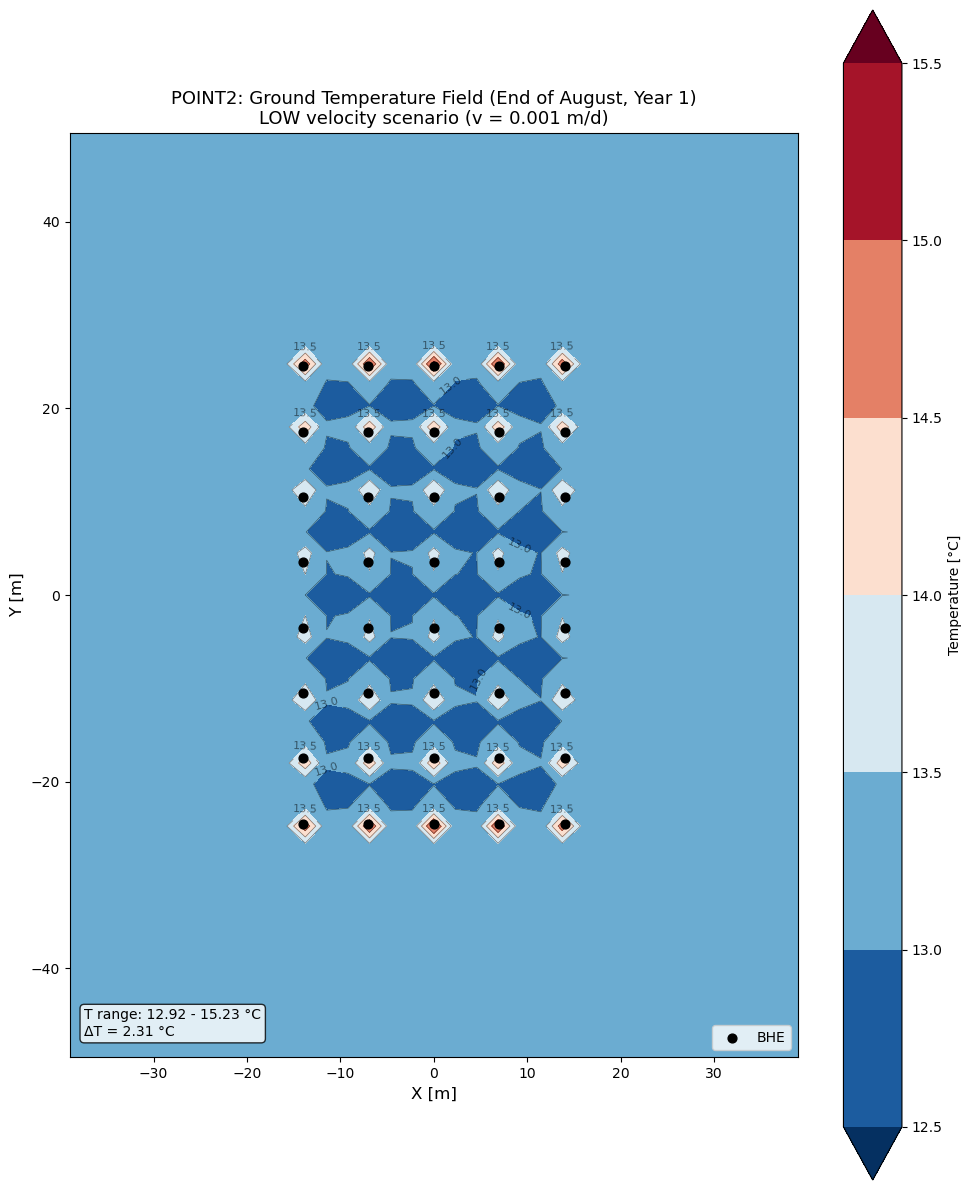


Contour figure saved to ..\figures\point2_gwflow_low_contour.png


In [21]:
# =====================================================
# Cell 13: Temperature Contour using POINT2 (Optimized)
# =====================================================
# Compute 2D temperature field at a representative time point

from pathlib import Path
import time

print("="*60)
print(f"Generating Temperature Contour - {scenario.upper()} Velocity")
print("="*60)

# Define grid for contour
margin = 25
x_min, x_max = bhe_x.min() - margin, bhe_x.max() + margin
y_min, y_max = bhe_y.min() - margin, bhe_y.max() + margin

# Moderate resolution grid
nx_grid, ny_grid = 35, 45  # 1575 points
x_grid = np.linspace(x_min, x_max, nx_grid)
y_grid = np.linspace(y_min, y_max, ny_grid)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

print(f"Grid: {nx_grid} x {ny_grid} = {nx_grid * ny_grid} points")

t_start = time.time()

# Use only 1 year of simulation (12 months)
n_mo_sim = 12
time_months_sim = np.arange(n_mo_sim + 1) * sec_per_mo

Finj_sim = []
for i_mo in range(n_mo_sim):
    sep_idx = i_mo % 12
    q_Wm = q_Wm_sep[sep_idx]
    row = [time_months_sim[i_mo]] + [q_Wm] * n_bhe
    Finj_sim.append(row)
Finj_sim = np.array(Finj_sim)

# Compute at end of August (peak injection - month 11 in SEP-start)
t_aug = 11 * sec_per_mo

print(f"Computing temperature at end of August (peak injection)...")

# Compute temperature at each grid point
T_grid = np.zeros((ny_grid, nx_grid))

for i in range(ny_grid):
    for j in range(nx_grid):
        try:
            T_response = bhe(
                Finj=Finj_sim,
                x=X_grid[i, j], y=Y_grid[i, j], t=t_aug,
                xc=bhe_x, yc=bhe_y,
                v=v_pore_ms,
                n=n_porosity,
                rho_s=rho_s, c_s=c_s, k_s=k_s,
                rho_w=rho_w, c_w=c_w, k_w=k_w,
                al=al, ah=ah,
                T0=0.0,
                order=20
            )
            T_grid[i, j] = T0_eff + T_response[0]
        except:
            T_grid[i, j] = T0_eff
    
    if (i+1) % 10 == 0:
        elapsed = time.time() - t_start
        rate = (i+1) / elapsed
        eta = (ny_grid - i - 1) / rate
        print(f"  Row {i+1}/{ny_grid} | {elapsed:.0f}s | ETA: {eta:.0f}s")

total_time = time.time() - t_start
print(f"\nComputation: {total_time:.1f}s ({total_time/60:.1f} min)")

T_range = T_grid.max() - T_grid.min()
print(f"Temperature: {T_grid.min():.2f} to {T_grid.max():.2f} °C (range: {T_range:.2f}°C)")

# Create figure
fig, ax = plt.subplots(figsize=(10, 12))

# Adaptive contour levels based on temperature range
if T_range > 2.0:
    # Large range: use 0.5°C intervals
    T_min_level = np.floor(T_grid.min() * 2) / 2
    T_max_level = np.ceil(T_grid.max() * 2) / 2
    levels = np.arange(T_min_level, T_max_level + 0.25, 0.5)
elif T_range > 0.5:
    # Medium range: use 0.2°C intervals
    T_min_level = np.floor(T_grid.min() * 5) / 5
    T_max_level = np.ceil(T_grid.max() * 5) / 5
    levels = np.arange(T_min_level, T_max_level + 0.1, 0.2)
else:
    # Small range: use 0.1°C intervals
    T_min_level = np.floor(T_grid.min() * 10) / 10
    T_max_level = np.ceil(T_grid.max() * 10) / 10
    levels = np.arange(T_min_level, T_max_level + 0.05, 0.1)

print(f"Contour levels: {levels}")

# Temperature contour
cf = ax.contourf(X_grid, Y_grid, T_grid, levels=levels, cmap='RdBu_r', extend='both')
cs = ax.contour(X_grid, Y_grid, T_grid, levels=levels, colors='black', linewidths=0.5, alpha=0.5)
ax.clabel(cs, inline=True, fontsize=8, fmt='%.1f')
cbar = plt.colorbar(cf, ax=ax, label='Temperature [°C]')

# BHE locations
ax.scatter(bhe_x, bhe_y, c='black', s=40, marker='o', label='BHE', zorder=5)

# Flow direction arrow
if v_darcy > 0.001:
    arrow_y = y_max - 8
    ax.annotate('', xy=(x_max-5, arrow_y), xytext=(x_min+5, arrow_y),
                arrowprops=dict(arrowstyle='->', color='black', lw=2.5))
    ax.text((x_min + x_max)/2, arrow_y + 5, f'Groundwater flow: v = {v_darcy} m/d', 
            fontsize=11, ha='center', fontweight='bold')

ax.set_xlabel('X [m]', fontsize=12)
ax.set_ylabel('Y [m]', fontsize=12)
ax.set_title(f'POINT2: Ground Temperature Field (End of August, Year 1)\n'
             f'{scenario.upper()} velocity scenario (v = {v_darcy} m/d)', fontsize=13)
ax.set_aspect('equal')
ax.legend(loc='lower right')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Add info text
info_text = f"T range: {T_grid.min():.2f} - {T_grid.max():.2f} °C\nΔT = {T_range:.2f} °C"
ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=10, 
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Save figure
fig_dir = Path("../figures")
fig_dir.mkdir(parents=True, exist_ok=True)
fig_path = fig_dir / f"point2_gwflow_{scenario}_contour.png"
plt.savefig(fig_path, dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nContour figure saved to {fig_path}")